In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
import sys
import pickle
from matplotlib.ticker import NullFormatter
import matplotlib.path as mpath
import matplotlib.patches as patches


path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    sys.path.append(path)

import neurolib.dashboard.data as data
from neurolib.models.aln import ALNModel
import neurolib.dashboard.layout as layout
import neurolib.dashboard.functions as functions
import neurolib.utils.func_optimize as fo


# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2    

In [2]:
cmap = layout.getcolormap()
darkgrey, midgrey, lightgrey, color_bi_updown, color_LC, color_bi_uposc = layout.getcolors()
exc_red = cmap(3)
inh_blue=cmap(0)
green = cmap(2)

rgb_cm = cmap.colors

aln = ALNModel()
data.set_parameters(aln)
state_vars = aln.state_vars

In [3]:
readpath = '.' + os.sep

with open(readpath + os.sep + 'bi.pickle','rb') as file:
    load_array= pickle.load(file)
ext_exc = load_array[0]
ext_inh = load_array[1]

grid_resolution = layout.grid_resolution

dist_up_regime = np.zeros((len(ext_exc), 2))
dist_down_regime = np.zeros((len(ext_exc)))

cmap = layout.getcolormap()
darkgrey, midgrey, lightgrey, color_bi_updown, color_LC, color_bi_uposc = layout.getcolors()
exc_red = cmap(3)
inh_blue=cmap(0)
green = cmap(2)
aln = ALNModel()
data.set_parameters(aln)
state_vars = aln.state_vars

def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]

In [ ]:
readpath = '.' + os.sep + 'data_final_current'
control_data = data.read_control(readpath, '3')
opt_control = control_data[2]
opt_state = control_data[3]
aln.params.duration = 500

compute for  42
compute for  48
compute for  55
compute for  62
compute for  69
compute for  76


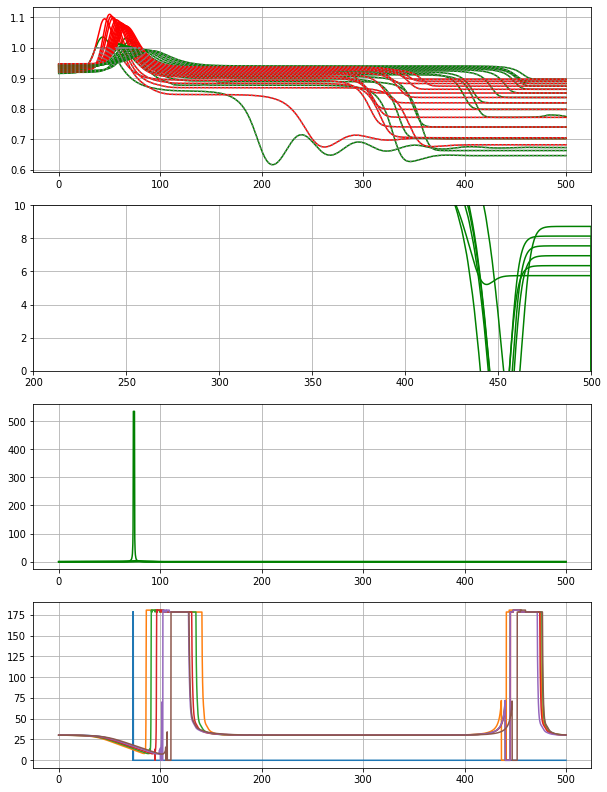

max :  1.035040754209851 1


In [126]:
seimax, i_seimax = 0., 0

fig, ax = plt.subplots(4, 1, figsize = (10,14))
time_array = np.arange(0,500.1, 0.1)

for i in range(len(opt_control)):
    if i == 83:
        break
        
    if ext_exc[i] > 0.46 or ext_exc[i] < 0.42:
        continue
        
    c_ = 'green'
    if ext_exc[i] > 0.43:
        c_ = 'red'
        
    #print(i, c_)
    
    control_current = opt_control[i][:,:,100:-100]
    state = opt_state[i][:,:,100:-100]
    sei, sei_control, rei, uei = compute_rei(control_current, state)
    
    if c_ == 'green':
        if np.amax(sei + state[0,6,:]) > seimax:
            seimax = np.amax(sei + state[0,6,:])
            i_seimax = i
    
    #print(type(sei), type(state))

        
    ax[0].plot(time_array, sei + state[0,6,:], color=c_)
    ax[0].plot(time_array, sei_control, color='gray', linestyle=':')
    
    if np.amax(rei) > 0.:
        print("compute for ", i)
        ax[1].plot(time_array, rei, color=c_)
        ax[2].plot(time_array, uei, color=c_)
        setinit(initVars, aln)
        aln.params.duration = 500
        fac_dt = 100
        aln.params.dt = 0.1 / fac_dt
        control_ = aln.getZeroControl()
        for t_ in range(control_.shape[2]-fac_dt):
            control_[0,3,t_:t_+fac_dt] = 2. * uei[int(t_/fac_dt)]
        aln.run(control = control_)
        ax[3].plot(aln.t, aln.rates_exc[0,:])
    
    
ax[1].set_xlim(200,500)
ax[1].set_ylim(0,10)
plt.show()


print('max : ', seimax, i_seimax)

# 48 55 62 69 76

In [123]:
def compute_rei(c_, state_):
    time_array = np.arange(0,500.1, 0.1)
    rei = np.zeros(( c_.shape[2] ))
    sei = rei.copy()
    ri = rei.copy()
    uei = rei.copy()
    sei[:] = c_[0,0,:] / aln.params.Jei_max
    
    #plt.plot(time_array, c_[0,0,:], color='blue')
    #plt.plot(time_array, sei + state_[0,6,:], color='orange')
    #plt.show()
    
    sei_control = sei + state_[0,6,:]
    sei_max = np.amax(sei_control)
    for t_ in range(len(sei_control)):
        if sei_control[t_] > 1.:
            sei_control[t_] = 1.
            
            
            
    if sei_max < 1.0001:
            
        for t_ in np.arange(len(rei)-1):
            seim_rhs = ( sei_control[t_+1] - sei_control[t_] ) / aln.params.dt
            
            if sei_control[t_] < 1.:
                rei[t_] = ( ( seim_rhs * aln.params.tau_si ) + sei_control[t_] ) / (1. - sei_control[t_])    
            else:
                rei[t_] = rei[t_-1]
            
            ri[t_] = rei[t_] * np.abs(aln.params.Jei_max) / (aln.params.cei * aln.params.Ki * aln.params.tau_si)

            if t_ > 10*aln.params.di:
                uei[t_] = rei[t_] - ( aln.params.cei * aln.params.Ki * aln.params.tau_si
                                     * state_[0,1,int(t_-10*aln.params.di)] * 1e-3 / np.abs(aln.params.Jei_max) )

                uei[t_] *= np.abs(aln.params.Jei_max) / ( aln.params.c_gl * aln.params.Ki_gl * aln.params.tau_si )
            
    return sei, sei_control, rei, uei

In [82]:
i = 10

aln.params.ext_exc_current = ext_exc[i] * 5.
aln.params.ext_inh_current = ext_inh[i] * 5.

aln.params.duration = 3000.

control0 = aln.getZeroControl()
control0 = functions.step_control(aln, maxI_ = 5.)
aln.run(control=control0)

init_state_vars = np.zeros(( len(state_vars) ))
for j in range(len(state_vars)):
    if aln.state[state_vars[j]].size == 1:
        init_state_vars[j] = aln.state[state_vars[j]][0]
    else:
        init_state_vars[j] = aln.state[state_vars[j]][0,-1]

initVars = init_state_vars

aln.params.duration = 500

5032 2.3636461229359327
0.015600064411377158
5033 2.363646353560889
0.015600065933501871
5034 2.3636465830603095
0.015600067448198045
5035 2.363646811439681
0.015600068955501896
5036 2.3636470387044706
0.015600070455449509
5037 2.3636472648601163
0.015600071948076768
5038 2.363647489912028
0.015600073433419386
5039 2.363647713865595
0.015600074911512928
5040 2.3636479367261725
0.01560007638239274
5041 2.3636481584990965
0.015600077846094037
5042 2.3636483791896716
0.015600079302651833
5043 2.3636485988031812
0.015600080752100998
5044 2.363648817344879
0.015600082194476202
5045 2.3636490348199946
0.015600083629811965
5046 2.3636492512337317
0.01560008505814263
5047 2.3636494665912706
0.015600086479502387
5048 2.3636496808977645
0.015600087893925248
5049 2.3636498941583413
0.015600089301445054
5050 2.3636501063781044
0.01560009070209549
5051 2.3636503175621324
0.015600092095910074
5052 2.3636505277154787
0.015600093482922161
5053 2.3636507368431725
0.01560009486316494
5054 2.363650944950

7169 2.3636933708317716
0.015600376247489693
7170 2.363693370838399
0.015600376247533436
7171 2.363693370844994
0.01560037624757696
7172 2.363693370851555
0.015600376247620262
7173 2.363693370858086
0.015600376247663368
7174 2.363693370864582
0.015600376247706245
7175 2.363693370871051
0.015600376247748937
7176 2.3636933708774843
0.0156003762477914
7177 2.3636933708838885
0.015600376247833666
7178 2.363693370890261
0.015600376247875724
7179 2.3636933708966006
0.015600376247917566
7180 2.3636933709029124
0.015600376247959223
7181 2.363693370909191
0.015600376248000663
7182 2.363693370915442
0.015600376248041918
7183 2.3636933709216597
0.015600376248082954
7184 2.3636933709278476
0.015600376248123797
7185 2.3636933709340044
0.01560037624816443
7186 2.363693370940132
0.015600376248204872
7187 2.36369337094623
0.01560037624824512
7188 2.3636933709522983
0.015600376248285171
7189 2.3636933709583374
0.01560037624832503
7190 2.3636933709643455
0.01560037624836468
7191 2.363693370970326
0.0156

9260 2.3636933721892013
0.01560037625644873
9261 2.3636933721892013
0.01560037625644873
9262 2.3636933721892013
0.01560037625644873
9263 2.3636933721892013
0.01560037625644873
9264 2.3636933721892013
0.01560037625644873
9265 2.363693372189203
0.015600376256448742
9266 2.363693372189203
0.015600376256448742
9267 2.363693372189203
0.015600376256448742
9268 2.363693372189203
0.015600376256448742
9269 2.363693372189203
0.015600376256448742
9270 2.363693372189203
0.015600376256448742
9271 2.363693372189203
0.015600376256448742
9272 2.363693372189203
0.015600376256448742
9273 2.363693372189203
0.015600376256448742
9274 2.363693372189203
0.015600376256448742
9275 2.363693372189203
0.015600376256448742
9276 2.3636933721892053
0.015600376256448755
9277 2.3636933721892053
0.015600376256448755
9278 2.3636933721892053
0.015600376256448755
9279 2.3636933721892053
0.015600376256448755
9280 2.3636933721892053
0.015600376256448755
9281 2.3636933721892053
0.015600376256448755
9282 2.3636933721892053
0.

11222 2.3636933721892457
0.015600376256449024
11223 2.3636933721892457
0.015600376256449024
11224 2.3636933721892457
0.015600376256449024
11225 2.3636933721892457
0.015600376256449024
11226 2.3636933721892457
0.015600376256449024
11227 2.3636933721892457
0.015600376256449024
11228 2.3636933721892457
0.015600376256449024
11229 2.3636933721892457
0.015600376256449024
11230 2.3636933721892457
0.015600376256449024
11231 2.3636933721892457
0.015600376256449024
11232 2.3636933721892457
0.015600376256449024
11233 2.3636933721892457
0.015600376256449024
11234 2.3636933721892457
0.015600376256449024
11235 2.3636933721892457
0.015600376256449024
11236 2.3636933721892457
0.015600376256449024
11237 2.3636933721892457
0.015600376256449024
11238 2.3636933721892457
0.015600376256449024
11239 2.3636933721892457
0.015600376256449024
11240 2.3636933721892457
0.015600376256449024
11241 2.3636933721892457
0.015600376256449024
11242 2.3636933721892457
0.015600376256449024
11243 2.3636933721892457
0.0156003

12712 2.3636933721892457
0.015600376256449024
12713 2.3636933721892457
0.015600376256449024
12714 2.3636933721892457
0.015600376256449024
12715 2.3636933721892457
0.015600376256449024
12716 2.3636933721892457
0.015600376256449024
12717 2.3636933721892457
0.015600376256449024
12718 2.3636933721892457
0.015600376256449024
12719 2.3636933721892457
0.015600376256449024
12720 2.3636933721892457
0.015600376256449024
12721 2.3636933721892457
0.015600376256449024
12722 2.3636933721892457
0.015600376256449024
12723 2.3636933721892457
0.015600376256449024
12724 2.3636933721892457
0.015600376256449024
12725 2.3636933721892457
0.015600376256449024
12726 2.3636933721892457
0.015600376256449024
12727 2.3636933721892457
0.015600376256449024
12728 2.3636933721892457
0.015600376256449024
12729 2.3636933721892457
0.015600376256449024
12730 2.3636933721892457
0.015600376256449024
12731 2.3636933721892457
0.015600376256449024
12732 2.3636933721892457
0.015600376256449024
12733 2.3636933721892457
0.0156003

14593 2.3636933721892457
0.015600376256449024
14594 2.3636933721892457
0.015600376256449024
14595 2.3636933721892457
0.015600376256449024
14596 2.3636933721892457
0.015600376256449024
14597 2.3636933721892457
0.015600376256449024
14598 2.3636933721892457
0.015600376256449024
14599 2.3636933721892457
0.015600376256449024
14600 2.3636933721892457
0.015600376256449024
14601 2.3636933721892457
0.015600376256449024
14602 2.3636933721892457
0.015600376256449024
14603 2.3636933721892457
0.015600376256449024
14604 2.3636933721892457
0.015600376256449024
14605 2.3636933721892457
0.015600376256449024
14606 2.3636933721892457
0.015600376256449024
14607 2.3636933721892457
0.015600376256449024
14608 2.3636933721892457
0.015600376256449024
14609 2.3636933721892457
0.015600376256449024
14610 2.3636933721892457
0.015600376256449024
14611 2.3636933721892457
0.015600376256449024
14612 2.3636933721892457
0.015600376256449024
14613 2.3636933721892457
0.015600376256449024
14614 2.3636933721892457
0.0156003

16656 13.746090833664965
0.09072419950218878
16657 13.746093839617833
0.0907242193414777
16658 13.746090833664965
0.09072419950218878
16659 13.746093839617833
0.0907242193414777
16660 13.746090833664965
0.09072419950218878
16661 13.746093839617833
0.0907242193414777
16662 13.746090833664965
0.09072419950218878
16663 13.746093839617833
0.0907242193414777
16664 13.746090833664965
0.09072419950218878
16665 13.746093839617833
0.0907242193414777
16666 13.746090833664965
0.09072419950218878
16667 13.746093839617833
0.0907242193414777
16668 13.746090833664965
0.09072419950218878
16669 13.746093839617833
0.0907242193414777
16670 13.746090833664965
0.09072419950218878
16671 13.746093839617833
0.0907242193414777
16672 13.746090833664965
0.09072419950218878
16673 13.746093839617833
0.0907242193414777
16674 13.746090833664965
0.09072419950218878
16675 13.746093839617833
0.0907242193414777
16676 13.746090833664965
0.09072419950218878
16677 13.746093839617833
0.0907242193414777
16678 13.746090833664

18731 12.422562796071402
0.08198891445407126
18732 12.422562549295282
0.08198891282534887
18733 12.422562306717964
0.08198891122433857
18734 12.422562068268002
0.08198890965056882
18735 12.422561833875164
0.08198890810357609
18736 12.422561603470413
0.08198890658290474
18737 12.422561376985904
0.08198890508810697
18738 12.422561154354941
0.08198890361874261
18739 12.422560935511962
0.08198890217437896
18740 12.422560720392536
0.08198890075459074
18741 12.422560508933328
0.08198889935895998
18742 12.422560301072082
0.08198889798707575
18743 12.422560096747596
0.08198889663853413
18744 12.422559895899722
0.08198889531293817
18745 12.42255969846933
0.08198889400989759
18746 12.422559504398302
0.0819888927290288
18747 12.422559313629497
0.0819888914699547
18748 12.422559126106766
0.08198889023230466
18749 12.422558941774897
0.08198888901571433
18750 12.422558760579616
0.08198888781982547
18751 12.422558582467582
0.08198888664428605
18752 12.42255840738636
0.08198888548874998
18753 12.42255

0.08198881873690932
20737 12.422548293471108
0.08198881873690932
20738 12.422548293471108
0.08198881873690932
20739 12.422548293471108
0.08198881873690932
20740 12.422548293471108
0.08198881873690932
20741 12.422548293471108
0.08198881873690932
20742 12.422548293471108
0.08198881873690932
20743 12.422548293471108
0.08198881873690932
20744 12.422548293471108
0.08198881873690932
20745 12.422548293471108
0.08198881873690932
20746 12.422548293471108
0.08198881873690932
20747 12.422548293471108
0.08198881873690932
20748 12.422548293471108
0.08198881873690932
20749 12.422548293471108
0.08198881873690932
20750 12.422548293471108
0.08198881873690932
20751 12.422548293471108
0.08198881873690932
20752 12.422548293471108
0.08198881873690932
20753 12.422548293471108
0.08198881873690932
20754 12.422548293471108
0.08198881873690932
20755 12.422548293471108
0.08198881873690932
20756 12.422548293471108
0.08198881873690932
20757 12.422548293471108
0.08198881873690932
20758 12.422548293471108
0.08198881

0.08198881873690932
22742 12.422548293471108
0.08198881873690932
22743 12.422548293471108
0.08198881873690932
22744 12.422548293471108
0.08198881873690932
22745 12.422548293471108
0.08198881873690932
22746 12.422548293471108
0.08198881873690932
22747 12.422548293471108
0.08198881873690932
22748 12.422548293471108
0.08198881873690932
22749 12.422548293471108
0.08198881873690932
22750 12.422548293471108
0.08198881873690932
22751 12.422548293471108
0.08198881873690932
22752 12.422548293471108
0.08198881873690932
22753 12.422548293471108
0.08198881873690932
22754 12.422548293471108
0.08198881873690932
22755 12.422548293471108
0.08198881873690932
22756 12.422548293471108
0.08198881873690932
22757 12.422548293471108
0.08198881873690932
22758 12.422548293471108
0.08198881873690932
22759 12.422548293471108
0.08198881873690932
22760 12.422548293471108
0.08198881873690932
22761 12.422548293471108
0.08198881873690932
22762 12.422548293471108
0.08198881873690932
22763 12.422548293471108
0.08198881

24682 12.422548293471108
0.08198881873690932
24683 12.422548293471108
0.08198881873690932
24684 12.422548293471108
0.08198881873690932
24685 12.422548293471108
0.08198881873690932
24686 12.422548293471108
0.08198881873690932
24687 12.422548293471108
0.08198881873690932
24688 12.422548293471108
0.08198881873690932
24689 12.422548293471108
0.08198881873690932
24690 12.422548293471108
0.08198881873690932
24691 12.422548293471108
0.08198881873690932
24692 12.422548293471108
0.08198881873690932
24693 12.422548293471108
0.08198881873690932
24694 12.422548293471108
0.08198881873690932
24695 12.422548293471108
0.08198881873690932
24696 12.422548293471108
0.08198881873690932
24697 12.422548293471108
0.08198881873690932
24698 12.422548293471108
0.08198881873690932
24699 12.422548293471108
0.08198881873690932
24700 12.422548293471108
0.08198881873690932
24701 12.422548293471108
0.08198881873690932
24702 12.422548293471108
0.08198881873690932
24703 12.422548293471108
0.08198881873690932
24704 12.4

26709 12.422548293471108
0.08198881873690932
26710 12.422548293471108
0.08198881873690932
26711 12.422548293471108
0.08198881873690932
26712 12.422548293471108
0.08198881873690932
26713 12.422548293471108
0.08198881873690932
26714 12.422548293471108
0.08198881873690932
26715 12.422548293471108
0.08198881873690932
26716 12.422548293471108
0.08198881873690932
26717 12.422548293471108
0.08198881873690932
26718 12.422548293471108
0.08198881873690932
26719 12.422548293471108
0.08198881873690932
26720 12.422548293471108
0.08198881873690932
26721 12.422548293471108
0.08198881873690932
26722 12.422548293471108
0.08198881873690932
26723 12.422548293471108
0.08198881873690932
26724 12.422548293471108
0.08198881873690932
26725 12.422548293471108
0.08198881873690932
26726 12.422548293471108
0.08198881873690932
26727 12.422548293471108
0.08198881873690932
26728 12.422548293471108
0.08198881873690932
26729 12.422548293471108
0.08198881873690932
26730 12.422548293471108
0.08198881873690932
26731 12.4

28714 12.422548293471108
0.08198881873690932
28715 12.422548293471108
0.08198881873690932
28716 12.422548293471108
0.08198881873690932
28717 12.422548293471108
0.08198881873690932
28718 12.422548293471108
0.08198881873690932
28719 12.422548293471108
0.08198881873690932
28720 12.422548293471108
0.08198881873690932
28721 12.422548293471108
0.08198881873690932
28722 12.422548293471108
0.08198881873690932
28723 12.422548293471108
0.08198881873690932
28724 12.422548293471108
0.08198881873690932
28725 12.422548293471108
0.08198881873690932
28726 12.422548293471108
0.08198881873690932
28727 12.422548293471108
0.08198881873690932
28728 12.422548293471108
0.08198881873690932
28729 12.422548293471108
0.08198881873690932
28730 12.422548293471108
0.08198881873690932
28731 12.422548293471108
0.08198881873690932
28732 12.422548293471108
0.08198881873690932
28733 12.422548293471108
0.08198881873690932
28734 12.422548293471108
0.08198881873690932
28735 12.422548293471108
0.08198881873690932
28736 12.4

In [83]:
setinit(initVars, aln)
state = fo.updateFullState(aln, opt_control[i][:,:,100:-100], aln.state_vars)

5032 2.363698213605944
0.015600408209799231
5033 2.3636981899713705
0.015600408053811047
5034 2.363698166452178
0.015600407898584377
5035 2.363698143047804
0.015600407744115507
5036 2.3636981197576827
0.015600407590400708
5037 2.36369809658126
0.01560040743743632
5038 2.363698073517981
0.015600407285218675
5039 2.3636980505672898
0.015600407133744115
5040 2.363698027728643
0.015600406983009043


[2.36369821 2.36369819 2.36369817 2.36369814 2.36369812 2.3636981
 2.36369807 2.36369805 2.36369803 0.        ]
[0.01560041 0.01560041 0.01560041 0.01560041 0.01560041 0.01560041
 0.01560041 0.01560041 0.01560041 0.        ]
[15.60040523 15.60040509 15.60040495 15.60040481 15.60040467 15.60040453
 15.60040439 15.60040425 15.60040412 15.60040398]
[ 4.68958206e-17 -8.20676860e-17  1.95399252e-17 -3.12638804e-17
  7.03437308e-17 -8.59756710e-17 -6.64357458e-17 -6.25277607e-17
  0.00000000e+00  0.00000000e+00]


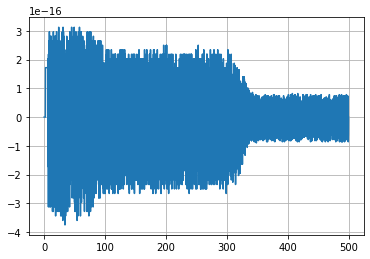

In [91]:
rei = np.zeros(( state.shape[2] ))
seim_rhs = rei.copy()
ri = rei.copy()
uei = rei.copy()

for t_ in np.arange(len(rei)-1):
    seim_rhs[t_] = ( state[0,6,t_+1] - state[0,6,t_] ) / aln.params.dt
    rei[t_] = ( ( seim_rhs[t_] * aln.params.tau_si ) + state[0,6,t_] ) / (1. - state[0,6,t_])
    ri[t_] = rei[t_] * np.abs(aln.params.Jei_max) / (aln.params.cei * aln.params.Ki * aln.params.tau_si)
    
    if t_ > 10*aln.params.di:
        uei[t_] = rei[t_] - ( aln.params.cei * aln.params.Ki * aln.params.tau_si
                             * state[0,1,int(t_-10*aln.params.di)] * 1e-3 / np.abs(aln.params.Jei_max) )

        uei[t_] *= np.abs(aln.params.Jei_max) / ( aln.params.c_gl * aln.params.Ki_gl * aln.params.tau_si )
    
print(rei[-10:])
print(ri[-10:])
print(state[0,1,-10:])
print(uei[-10:])

plt.plot(time_array, uei)